In [1]:
import argparse
import hashlib

from queryvolution.src.common import KeywordExtractor, generate_known_queries, setup_logger
from queryvolution.src.email_extraction import split_df, extract_sent_mail_contents, extract_apache_ml, load_preprocessed_enron_float32
from queryvolution.src.artificial_extraction import ArtificialExtractor
from queryvolution.src.artificial_query_generator import ArtificialQueryResultExtractor

from queryvolution.src.query_generator import QueryResultExtractor, ObfuscatedResultExtractor, PaddedResultExtractor
from queryvolution.src.matchmaker import KeywordTrapdoorMatchmaker

import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import random

# import ray

from scipy.special import comb

In [2]:
mpl.rcParams['figure.dpi'] = 600

plt.rcParams["figure.figsize"] = (12,8)
mpl.rc('text', usetex = True)

In [3]:
# ray.init()

In [4]:
def func_log(x, a, b, c):
    """Return values from a log function."""
    return a*np.log2(b+x)+c

def func_log_der(x, a, b, c):
    return a / ((b + x) * np.log(2))

In [5]:
document_keyword_occurrence, sorted_keyword_voc, sorted_keyword_occ = load_preprocessed_enron_float32(prefix='')

# Split to N sparse tensors: one sparse tensor per email
emails = tf.sparse.split(
    sp_input=document_keyword_occurrence,
    num_split=document_keyword_occurrence.dense_shape[0],
    axis=0
)

print(f"emails len: {len(emails)}")

emails len: 30109


# Single keyword

In [6]:
# Settings for single keyword
single_keyword_similar_voc_size = 4000
single_keyword_server_voc_size = 4000

single_keyword_query_set_size = int(0.15 * single_keyword_server_voc_size)

single_artificial_keyword_size = 1  # disables artificial kws

In [7]:
# Extract emails from a dataset

single_keyword_email_ids = list(range(document_keyword_occurrence.dense_shape[0]))
random.shuffle(single_keyword_email_ids)

single_similar_doc_ids, single_stored_doc_ids = single_keyword_email_ids[:int(len(emails) * 0.4)], single_keyword_email_ids[int(len(emails) * 0.4):]
print(f"Generated random email ids")

single_keyword_similar_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in single_similar_doc_ids], axis=0)
print(f"Similar docs shape: {single_keyword_similar_docs.dense_shape}")

single_keyword_stored_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in single_stored_doc_ids], axis=0)
print(f"Stored docs shape: {single_keyword_stored_docs.dense_shape}")

Generated random email ids
Similar docs shape: [12043 62976]
Stored docs shape: [18066 62976]


In [8]:
## Extract keywords from similar dataset
# single_keyword_similar_extractor = KeywordExtractor(
#     corpus_df=single_keyword_similar_docs,
#     voc_size=single_keyword_similar_voc_size,
#     min_freq=1,
#     with_artificial_kw_size=single_artificial_keyword_size
# )

single_keyword_similar_extractor = ArtificialExtractor(
    occurrence_array=single_keyword_similar_docs,
    keyword_voc=sorted_keyword_voc,
    keyword_occ=sorted_keyword_occ,
    voc_size=single_keyword_similar_voc_size,
    artificial_kw_size=single_artificial_keyword_size,
    min_freq=1,
    precalculated_artificial_keyword_combinations_indices=None,
    multi_core=False,
)

In [9]:
# Extract keywords from real dataset
# single_keyword_real_extractor = QueryResultExtractor(
#     single_keyword_stored_docs,
#     single_keyword_server_voc_size,
#     min_freq=1,
#     with_artificial_kw_size=single_artificial_keyword_size
# )

single_keyword_real_extractor = ArtificialQueryResultExtractor(
    single_keyword_stored_docs,
    sorted_keyword_voc,
    sorted_keyword_occ,
    single_keyword_server_voc_size,
    single_artificial_keyword_size,
    1,
    None,
    False,
)

In [10]:
single_keyword_similar_keyword_counts = np.array([count for count in single_keyword_similar_extractor.occurrences])
single_keyword_real_keyword_counts = np.array([count for count in single_keyword_real_extractor.occurrences])

single_keyword_y_sim = single_keyword_similar_keyword_counts / single_keyword_similar_docs.shape[0]
single_keyword_y_real = single_keyword_real_keyword_counts/ single_keyword_stored_docs.shape[0]

# Two keywords - Artificial keyword

In [11]:
# Settings for articial keyword with two keywords concatenated
two_keywords_similar_voc_size = 90
two_keywords_server_voc_size = 90

two_keywords_artificial_keyword_size = 2

two_keywords_query_set_size = int(comb(two_keywords_server_voc_size, two_keywords_artificial_keyword_size, exact=True) * 0.15)

In [12]:
# Extract emails from a dataset
two_keywords_email_ids = list(range(document_keyword_occurrence.dense_shape[0]))
random.shuffle(two_keywords_email_ids)

two_similar_doc_ids, two_stored_doc_ids = two_keywords_email_ids[:int(len(emails) * 0.4)], two_keywords_email_ids[int(len(emails) * 0.4):]
print(f"Generated random email ids")

two_keywords_similar_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in two_similar_doc_ids], axis=0)
print(f"Similar docs shape: {two_keywords_similar_docs.dense_shape}")

two_keywords_stored_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in two_stored_doc_ids], axis=0)
print(f"Stored docs shape: {two_keywords_stored_docs.dense_shape}")

Generated random email ids
Similar docs shape: [12043 62976]
Stored docs shape: [18066 62976]


In [13]:
## Extract keywords from similar dataset
# two_keywords_similar_extractor = KeywordExtractor(
#     corpus_df=two_keywords_similar_docs,
#     voc_size=two_keywords_similar_voc_size,
#     min_freq=1,
#     with_artificial_kw_size=two_keywords_artificial_keyword_size
# )

two_keywords_similar_extractor = ArtificialExtractor(
    occurrence_array=two_keywords_similar_docs,
    keyword_voc=sorted_keyword_voc,
    keyword_occ=sorted_keyword_occ,
    voc_size=two_keywords_similar_voc_size,
    artificial_kw_size=two_keywords_artificial_keyword_size,
    min_freq=1,
    precalculated_artificial_keyword_combinations_indices=None,
    multi_core=False,
)

In [14]:
# Extract keywords from real dataset
# two_keywords_real_extractor = QueryResultExtractor(
#     two_keywords_stored_docs,
#     two_keywords_server_voc_size,
#     min_freq=1,
#     with_artificial_kw_size=two_keywords_artificial_keyword_size
# )

two_keywords_real_extractor = ArtificialQueryResultExtractor(
    two_keywords_stored_docs,
    sorted_keyword_voc,
    sorted_keyword_occ,
    two_keywords_server_voc_size,
    two_keywords_artificial_keyword_size,
    1,
    None,
    False,
)

In [15]:
two_keywords_similar_keyword_counts = np.array([count for count in two_keywords_similar_extractor.occurrences])
two_keywords_real_keyword_counts = np.array([count for count in two_keywords_real_extractor.occurrences])

print(two_keywords_similar_extractor.sorted_voc[:10])
print(two_keywords_real_extractor.sorted_voc[:10])

two_keywords_y_sim = two_keywords_similar_keyword_counts / two_keywords_similar_docs.shape[0]
two_keywords_y_real = two_keywords_real_keyword_counts/ two_keywords_stored_docs.shape[0]

tf.Tensor(
[b'pm|thank' b'pm|enron' b'pm|pleas' b'pm|ect' b'pm|forward' b'pm|know'
 b'pm|would' b'pm|let' b'pm|get' b'pm|need'], shape=(10,), dtype=string)
tf.Tensor(
[b'pm|thank' b'pm|enron' b'pm|pleas' b'pm|ect' b'pm|forward' b'pm|know'
 b'pm|would' b'pm|get' b'pm|let' b'pm|need'], shape=(10,), dtype=string)


In [16]:
two_keywords_similar_column_sums = tf.reduce_sum(two_keywords_similar_extractor.occ_array, 0)
two_keywords_real_column_sums = tf.reduce_sum(two_keywords_real_extractor.occ_array, 0)

# First sort the sums, since they won't necessarily be sorted
two_keywords_similar_column_sums = tf.sort(two_keywords_similar_column_sums, direction='DESCENDING')
two_keywords_real_column_sums = tf.sort(two_keywords_real_column_sums, direction='DESCENDING')

two_keywords_y_sim = two_keywords_similar_column_sums / two_keywords_similar_docs.shape[0]
two_keywords_y_real = two_keywords_real_column_sums/ two_keywords_stored_docs.shape[0]

# Three keywords - Artificial keyword

In [17]:
# Settings for articial keyword with two keywords concatenated
three_keywords_similar_voc_size = 30
three_keywords_server_voc_size = 30

three_keywords_artificial_keyword_size = 3

three_keywords_query_set_size = int(comb(three_keywords_server_voc_size, three_keywords_artificial_keyword_size, exact=True) * 0.15)

In [18]:
# Extract emails from a dataset
three_keywords_email_ids = list(range(document_keyword_occurrence.dense_shape[0]))
random.shuffle(three_keywords_email_ids)

three_similar_doc_ids, three_stored_doc_ids = three_keywords_email_ids[:int(len(emails) * 0.4)], three_keywords_email_ids[int(len(emails) * 0.4):]
print(f"Generated random email ids")

three_keywords_similar_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in three_similar_doc_ids], axis=0)
print(f"Similar docs shape: {three_keywords_similar_docs.dense_shape}")

three_keywords_stored_docs = tf.sparse.concat(sp_inputs=[emails[i] for i in three_stored_doc_ids], axis=0)
print(f"Stored docs shape: {three_keywords_stored_docs.dense_shape}")

Generated random email ids
Similar docs shape: [12043 62976]
Stored docs shape: [18066 62976]


In [19]:
three_keywords_similar_extractor = ArtificialExtractor(
    occurrence_array=three_keywords_similar_docs,
    keyword_voc=sorted_keyword_voc,
    keyword_occ=sorted_keyword_occ,
    voc_size=three_keywords_similar_voc_size,
    artificial_kw_size=three_keywords_artificial_keyword_size,
    min_freq=1,
    precalculated_artificial_keyword_combinations_indices=None,
    multi_core=False,
)

In [20]:
three_keywords_real_extractor = ArtificialQueryResultExtractor(
    three_keywords_stored_docs,
    sorted_keyword_voc,
    sorted_keyword_occ,
    three_keywords_server_voc_size,
    three_keywords_artificial_keyword_size,
    1,
    None,
    False,
)

In [21]:
print(three_keywords_similar_extractor.sorted_voc[:10])
print(three_keywords_real_extractor.sorted_voc[:10])

tf.Tensor(
[b'pm|thank|enron' b'pm|thank|pleas' b'pm|thank|forward' b'pm|thank|ect'
 b'pm|thank|know' b'pm|thank|would' b'pm|thank|let' b'pm|thank|get'
 b'pm|thank|need' b'pm|thank|time'], shape=(10,), dtype=string)
tf.Tensor(
[b'pm|thank|enron' b'pm|thank|pleas' b'pm|thank|ect' b'pm|thank|forward'
 b'pm|thank|know' b'pm|thank|would' b'pm|thank|get' b'pm|thank|let'
 b'pm|thank|need' b'pm|thank|time'], shape=(10,), dtype=string)


In [22]:
three_keywords_similar_column_sums = tf.reduce_sum(three_keywords_similar_extractor.occ_array, 0)
three_keywords_real_column_sums = tf.reduce_sum(three_keywords_real_extractor.occ_array, 0)

# First sort the sums, since they won't necessarily be sorted
three_keywords_similar_column_sums = tf.sort(three_keywords_similar_column_sums, direction='DESCENDING')
three_keywords_real_column_sums = tf.sort(three_keywords_real_column_sums, direction='DESCENDING')

three_keywords_y_sim = three_keywords_similar_column_sums / three_keywords_similar_docs.shape[0]
three_keywords_y_real = three_keywords_real_column_sums/ three_keywords_stored_docs.shape[0]

# Plots 🎉

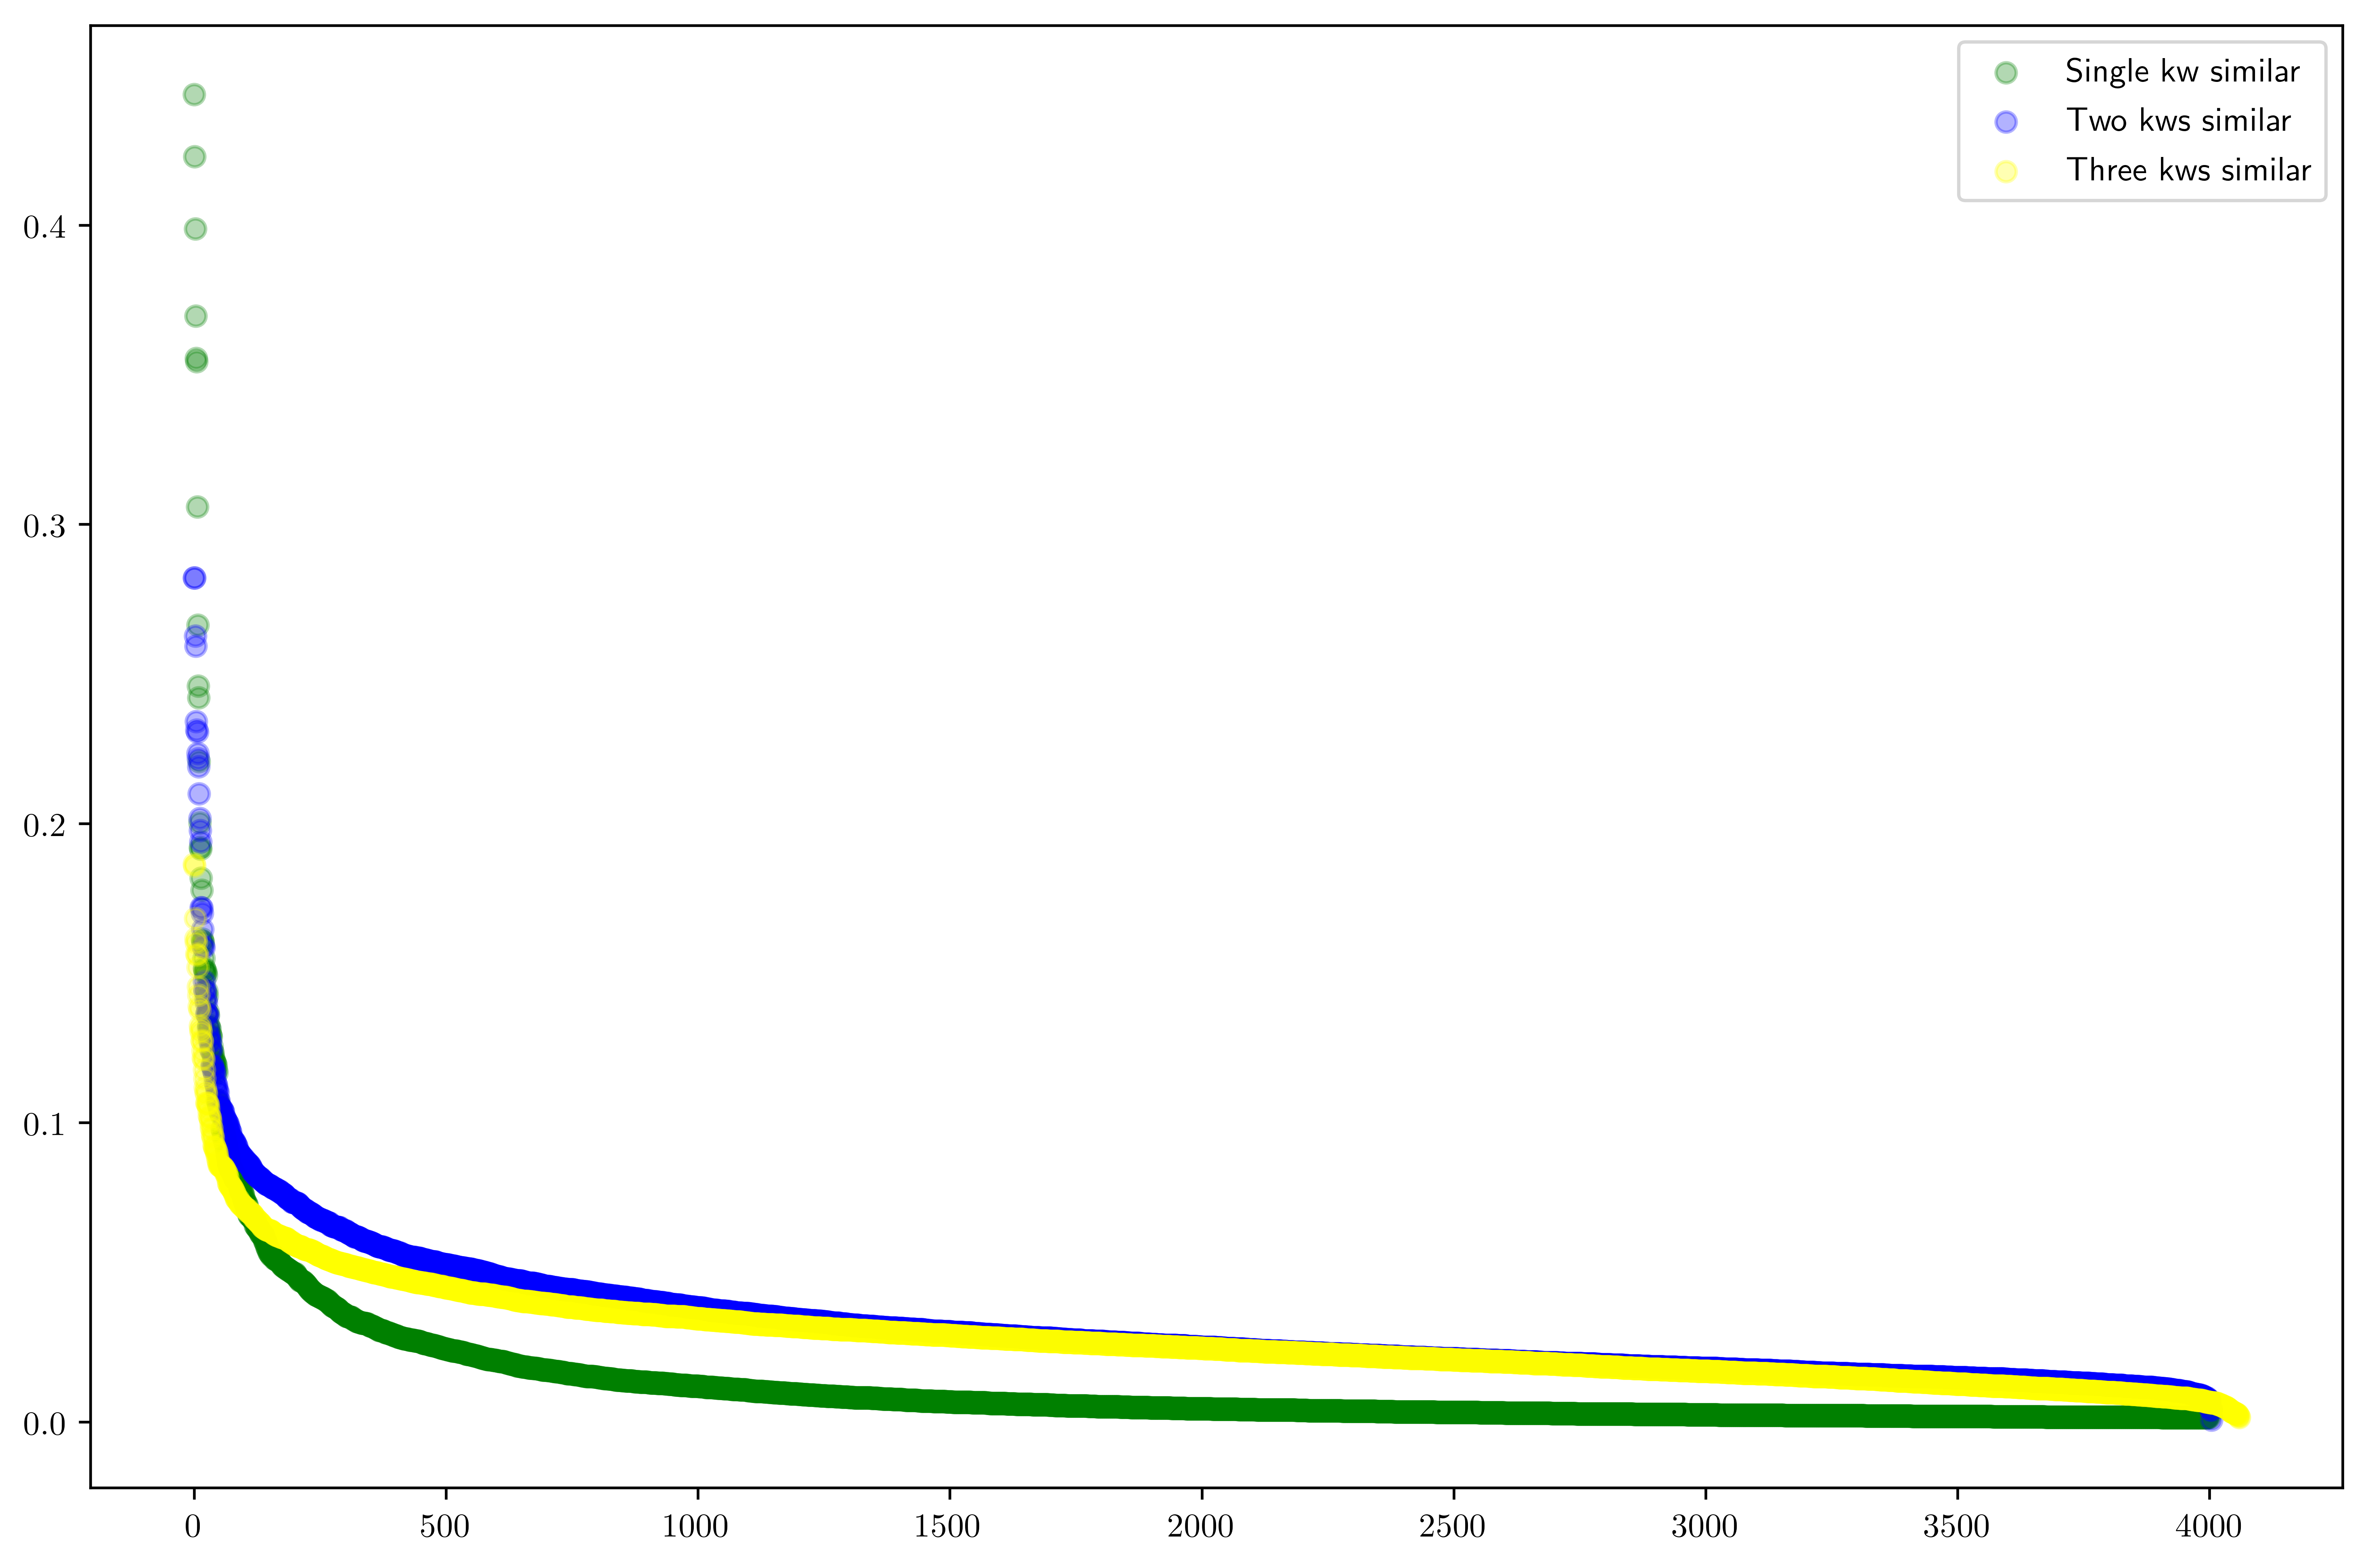

In [23]:
single_keyword_X_train = np.array(list(range(len(single_keyword_y_sim))))
two_keywords_X_train = np.array(list(range(len(two_keywords_y_sim))))
three_keywords_X_train = np.array(list(range(len(three_keywords_y_sim))))

plt.scatter(single_keyword_X_train, single_keyword_y_sim, color='green', alpha=0.3, label='Single kw similar')
plt.scatter(two_keywords_X_train, two_keywords_y_sim, color='blue', alpha=0.3, label='Two kws similar')
plt.scatter(three_keywords_X_train, three_keywords_y_sim, color='yellow', alpha=0.3, label='Three kws similar')
plt.legend()
plt.show()

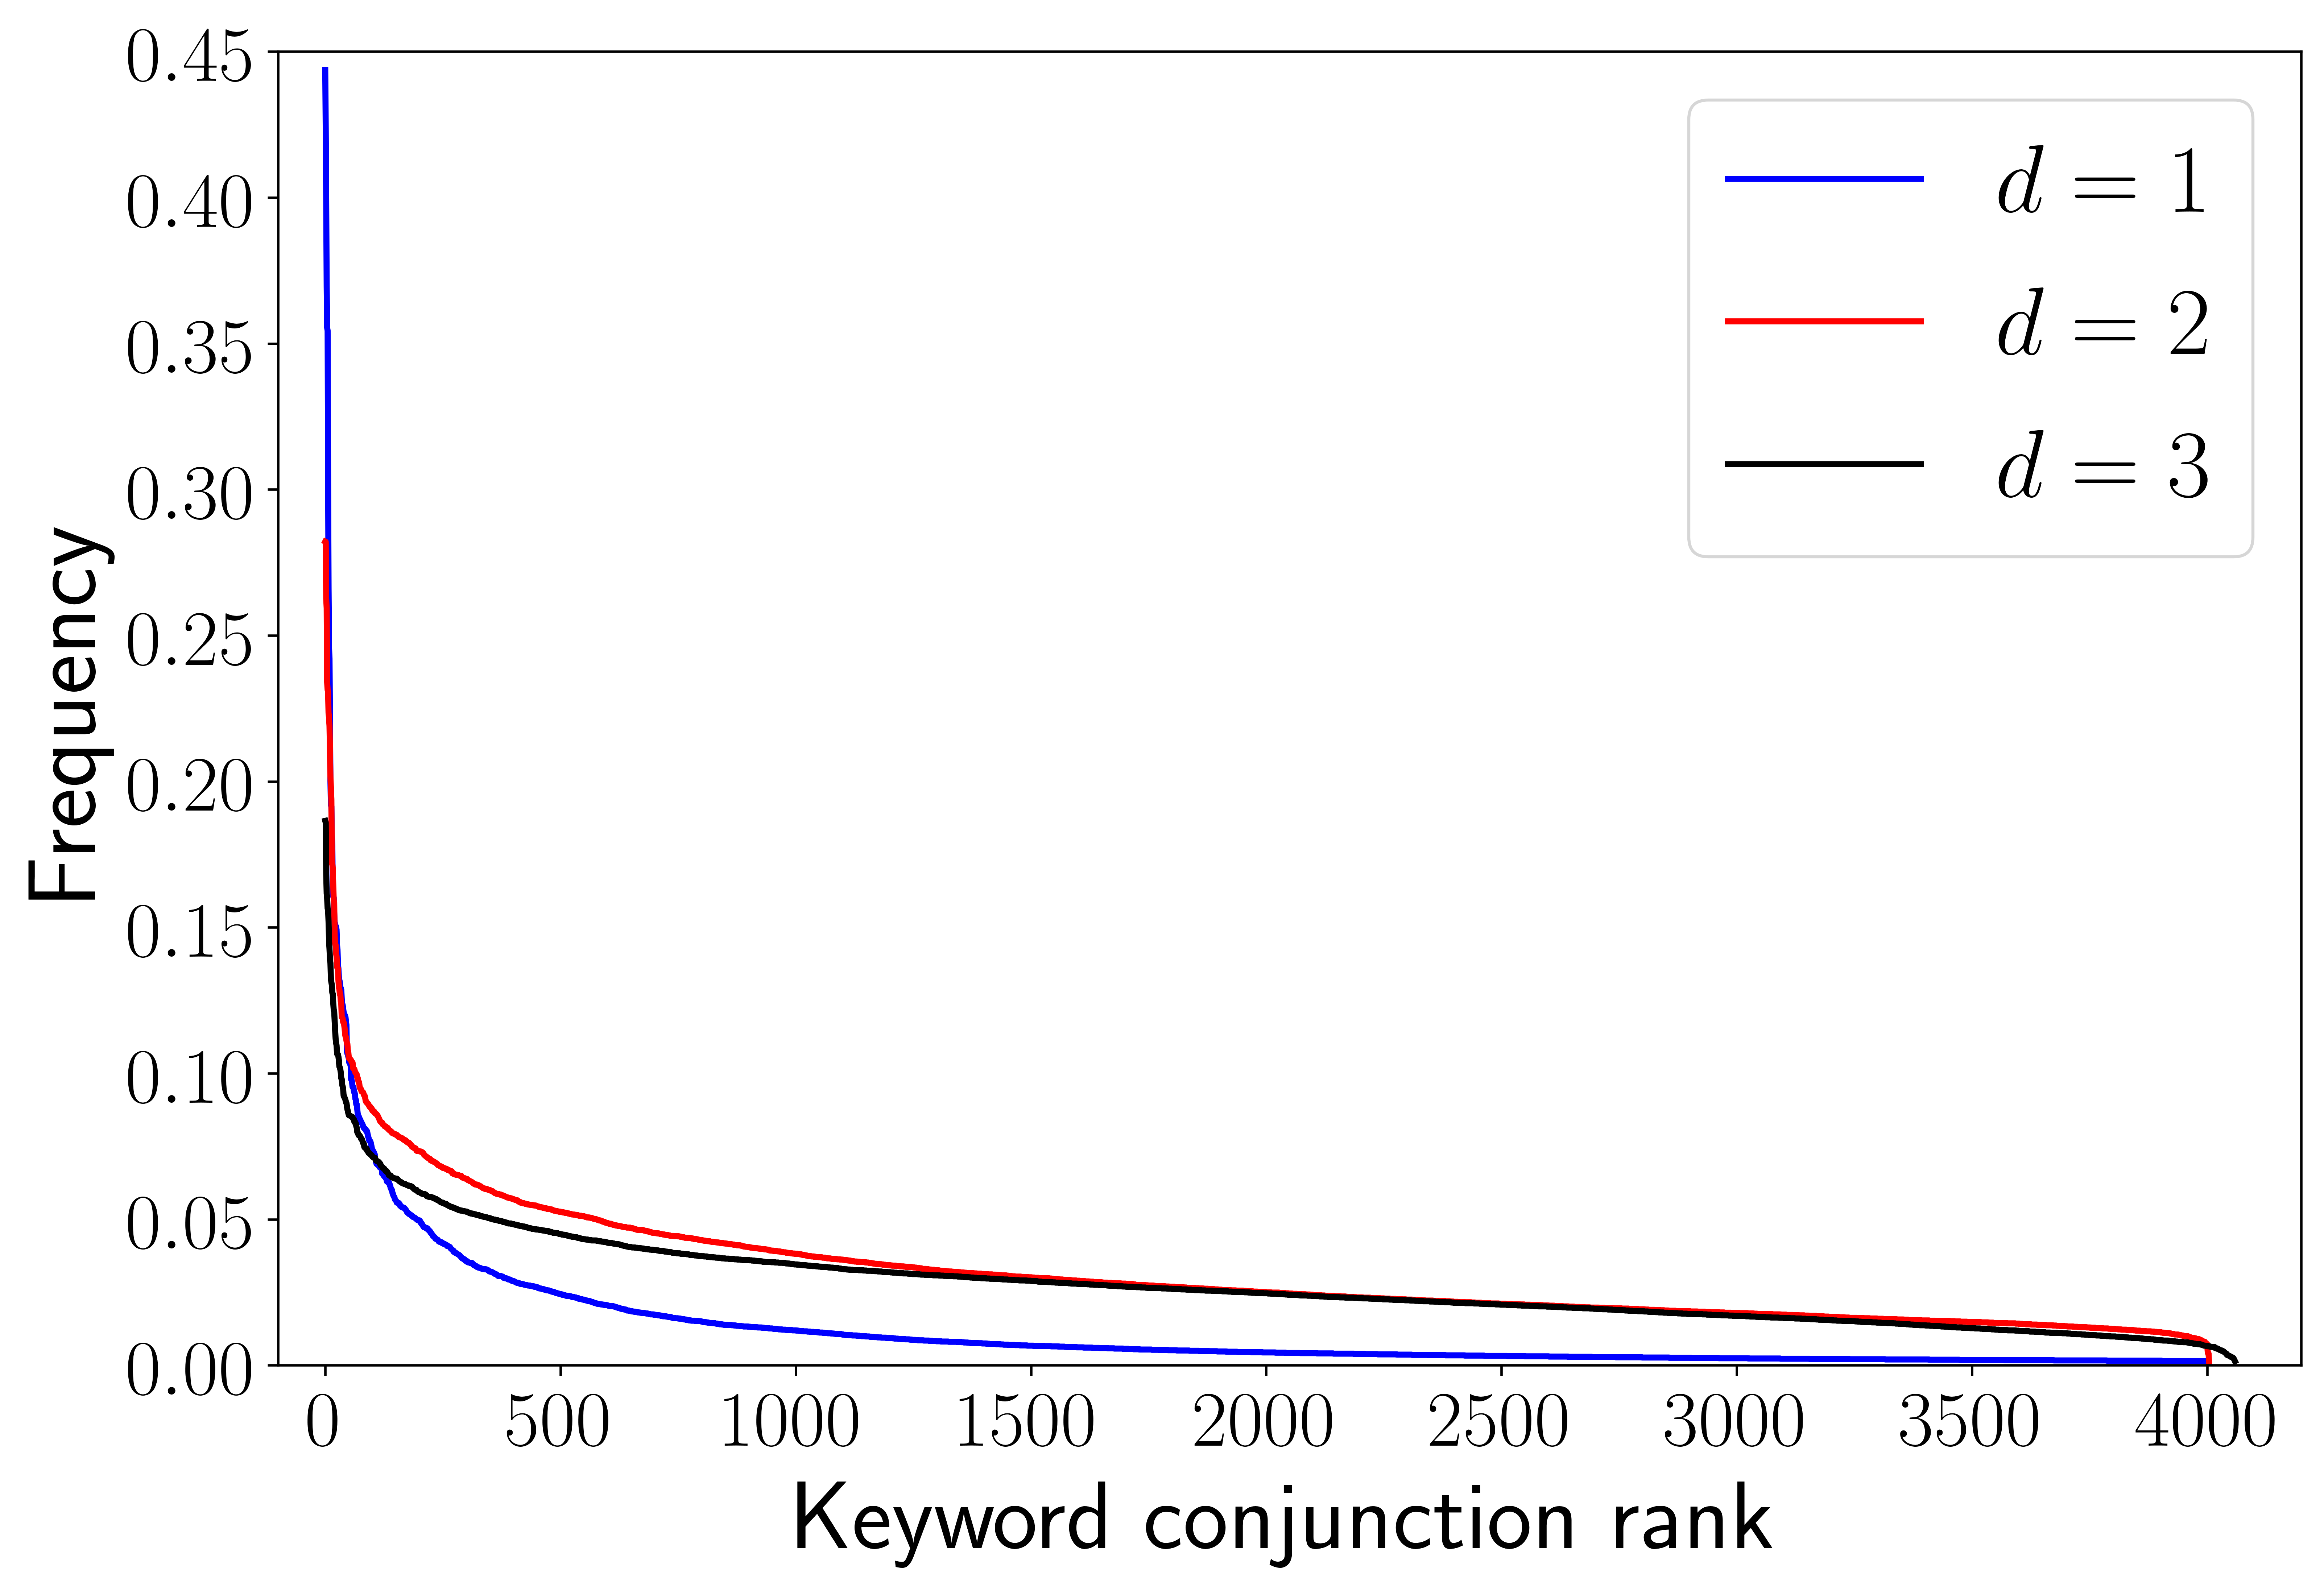

In [24]:
single_keyword_X_train = np.array(list(range(len(single_keyword_y_sim))))
two_keywords_X_train = np.array(list(range(len(two_keywords_y_sim))))
three_keywords_X_train = np.array(list(range(len(three_keywords_y_sim))))

plt.rcParams["figure.figsize"] = (12,8)

plt.plot(single_keyword_X_train, single_keyword_y_sim, color='b', label='$d = 1$', linewidth=2)
plt.plot(two_keywords_X_train, two_keywords_y_sim, color='r', label='$d = 2$', linewidth=2)
plt.plot(three_keywords_X_train, three_keywords_y_sim, color='k', label='$d = 3$', linewidth=2)
plt.legend(fontsize=32)

plt.ylabel("Frequency", fontsize=32)
plt.xlabel("Keyword conjunction rank", fontsize=32)
plt.xlim(left=-100, right=4200)
plt.ylim(bottom=0.0, top=0.45)

plt.yticks(np.arange(0, 0.5, step=0.05), fontsize=26)
plt.xticks(fontsize=26)

plt.savefig('keyword-rank-frequency.eps', format='eps')

plt.show()

In [ ]:
diff_single_X_train = np.array(list(range(len(single_keyword_y_sim))))
diff_two_X_train = np.array(list(range(len(two_keywords_y_sim))))[:len(diff_single_X_train)]

diff_y_a = single_keyword_y_sim - two_keywords_y_sim[:len(single_keyword_y_sim)]
diff_y_b = two_keywords_y_sim[:len(single_keyword_y_sim)] - single_keyword_y_sim

plt.plot(diff_y_a, label='Single kws - Two kws')
plt.legend()
plt.show()
plt.plot(diff_y_b, label='Two kws - Single kws', color='green')
plt.legend()
plt.show()

plt.plot(diff_y_a, label='Single kws - Two kws')
plt.plot(diff_y_b, label='Two kws - Single kws', color='green')

plt.plot(single_keyword_X_train, single_keyword_y_sim, color='green', alpha=0.3, label='Single kw similar')
plt.plot(two_keywords_X_train, two_keywords_y_sim, color='blue', alpha=0.3, label='Two kws similar')
plt.legend()
plt.show()

plt.plot(np.abs(diff_y_a), label='Abs diff')
plt.plot(single_keyword_X_train, single_keyword_y_sim, color='green', alpha=0.3, label='Single kw similar')
plt.plot(two_keywords_X_train, two_keywords_y_sim, color='blue', alpha=0.3, label='Two kws similar')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.abs(diff_y_a), label='Abs diff')
plt.plot(single_keyword_X_train, single_keyword_y_sim, color='green', alpha=0.3, label='Single kw similar')
plt.plot(two_keywords_X_train, two_keywords_y_sim, color='blue', alpha=0.3, label='Two kws similar')
plt.xlim(left=1000, right=4000)
plt.ylim(bottom=0.0, top=0.04)
plt.legend()
plt.show()

## Fitting curve for derivative

In [ ]:
def sigmoid(x, x0, k):
    y = 1 / (1+ np.exp(-k*(x-x0)))
    return y

def sigmoid2(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def func(x, a, b):
    return a * np.exp(-b * x)

def logit2(x,L,c,k):
    return L/ (1 + c*np.exp(-k*x))


single_keyword_X_train = single_keyword_X_train[1000:]
single_keyword_y_sim = single_keyword_y_sim[1000:]

two_keywords_X_train = two_keywords_X_train[1000:]
two_keywords_y_sim = two_keywords_y_sim[1000:]

In [ ]:
selected_func = func

In [ ]:
single_popt, single_pcov = curve_fit(
    selected_func, 
    single_keyword_X_train, 
    single_keyword_y_sim,
#     p0 = [max(single_keyword_y_sim), np.median(single_keyword_X_train),1,min(single_keyword_y_sim)],
    p0 = [1e-10,1e-10],
    maxfev=12000
)

two_popt, two_pcov = curve_fit(
    selected_func, 
    two_keywords_X_train, 
    two_keywords_y_sim,
#     p0 = [max(two_keywords_y_sim), np.median(two_keywords_X_train),1,min(two_keywords_y_sim)],
    p0 = [1e-10,1e-10],
    maxfev=12000
)

In [ ]:
xs = np.linspace(1000, 4000, 100)

plt.plot(single_keyword_X_train, single_keyword_y_sim, label='Original single kw', color='green', alpha=0.6)
plt.plot(xs, selected_func(xs, *single_popt), label='Fitted single kw', color='green')

plt.legend()
plt.show()


In [ ]:
plt.plot(two_keywords_X_train, two_keywords_y_sim, label='Original two kws', color='red', alpha=0.6)
plt.plot(xs, selected_func(xs, *two_popt), label='Fitted Two kws', color='red')

plt.legend()
plt.show()

In [ ]:
plt.plot(single_keyword_X_train, single_keyword_y_sim, label='Original single kw', color='green', alpha=0.6)
plt.plot(two_keywords_X_train, two_keywords_y_sim, label='Original two kws', color='red', alpha=0.6)

plt.plot(xs, selected_func(xs, *single_popt), label='Fitted single kw', color='green')
plt.plot(xs, selected_func(xs, *two_popt), label='Fitted Two kws', color='red')

plt.plot(xs, selected_func(xs, *two_popt) - selected_func(xs, *single_popt), label='Difference', color='blue')

plt.legend()
plt.show()